In [1]:
import numpy as np
import pandas as pd

## 训练数据处理

In [2]:
weather_data = np.load('weather_data.npz')
vi_data = np.load('crop_data.npz')
freq_data = np.load('crop_data_freq.npz') #每个阶段持续天数

In [3]:
weather = weather_data['arr_0']
vi = vi_data['arr_0']
freq = freq_data['arr_0']

In [5]:
print(weather.shape)
#(index,stage,var)
print(vi.shape)
#(index,var,stage,var_y,var_x)
print(freq.shape)

(557, 8, 9)
(557, 8, 8, 2, 2)
(557, 8)


In [7]:
weather_2D = np.reshape(weather,(557,weather.shape[1]*weather.shape[2]))
weather_2D.shape

(557, 72)

In [9]:
vi_3D = np.mean(np.mean(vi,axis=4),axis=3)
vi_3D.shape

(557, 8, 8)

In [10]:
vi_n8_2D = np.reshape(vi_3D,(557,vi_3D.shape[1]*vi_3D.shape[2]),order='F') #按列合并
vi_n8_2D.shape

(557, 64)

In [12]:
vi_n4_3D = np.delete(vi_3D,np.arange(4,8),axis=1)
print(vi_n4_3D.shape)
vi_n4_2D = np.reshape(vi_n4_3D,(557,vi_n4_3D.shape[1]*vi_n4_3D.shape[2]),order='F') #按列合并
vi_n4_2D.shape

(557, 4, 8)


(557, 32)

In [14]:
index = pd.read_csv('Crop_Yield_Data_challenge_2.csv')
index

,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Rice Yield (kg/ha)
0,Chau_Phu,10.510542,105.248554,SA,T,15-07-2022,3.40,5500
1,Chau_Phu,10.509150,105.265098,SA,T,15-07-2022,2.43,6000
2,Chau_Phu,10.467721,105.192464,SA,D,15-07-2022,1.95,6400
3,Chau_Phu,10.494453,105.241281,SA,T,15-07-2022,4.30,6000
4,Chau_Phu,10.535058,105.252744,SA,D,14-07-2022,3.30,6400
...,...,...,...,...,...,...,...,...
552,Thoai_Son,10.364419,105.164984,WS,T,12-04-2022,7.80,6640
553,Thoai_Son,10.358094,105.189541,WS,T,12-04-2022,2.00,7200
554,Thoai_Son,10.368014,105.238516,WS,T,12-04-2022,6.20,7200
555,Thoai_Son,10.275419,105.234563,WS,T,20-04-2022,3.00,6400


In [15]:
n_cycle = pd.get_dummies(index['Rice Crop Intensity(D=Double, T=Triple)'])  #生成D、T两列
n_cycle = np.reshape(np.array(n_cycle['D']),(-1,1))   #以D=1，T=1，(-1,1)指转化为一列
field_size = np.reshape(np.array(index['Field size (ha)']),(-1,1))

In [17]:
y_train = index['Rice Yield (kg/ha)']
y_train.shape

(557,)

In [18]:
#合并预测变量
X_train_8vi = np.concatenate((weather_2D, vi_n8_2D, freq, n_cycle, field_size),axis=1)
X_train_8vi.shape

(557, 146)

In [19]:
X_train_4vi = np.concatenate((weather_2D, vi_n4_2D, freq, n_cycle, field_size),axis=1)
X_train_4vi.shape

(557, 114)

## 开始建模

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

首先使用默认模型测试效果

In [21]:
rf0 = RandomForestRegressor(n_jobs=-1, random_state=28)

In [22]:
cv0_8vi = cross_val_score(rf0, X_train_8vi, y_train,
                          scoring='r2',
                          cv=3,
                          n_jobs=-1).mean()
cv0_8vi

0.6380755727957599

In [23]:
cv0_4vi = cross_val_score(rf0, X_train_4vi, y_train,
                          scoring='r2',
                          cv=3,
                          n_jobs=-1).mean()
cv0_4vi

0.6309962127879817

### 参数调节

#### 8个VI

调节`n_estimators`参数，分为两步：先确定大致范围，再具体到个位数

In [34]:
cv_score_list = []
for i in range(50,250,10):
    rf = RandomForestRegressor(n_estimators=i,
                               n_jobs=-1, random_state=28)
    cv_score = cross_val_score(rf, X_train_8vi, y_train,
                               scoring='r2',
                               cv=3,
                               n_jobs=-1).mean()
    cv_score_list.append(cv_score)
print(max(cv_score_list),([*range(50,250,10)][cv_score_list.index(max(cv_score_list))]))

0.6380755727957599 100


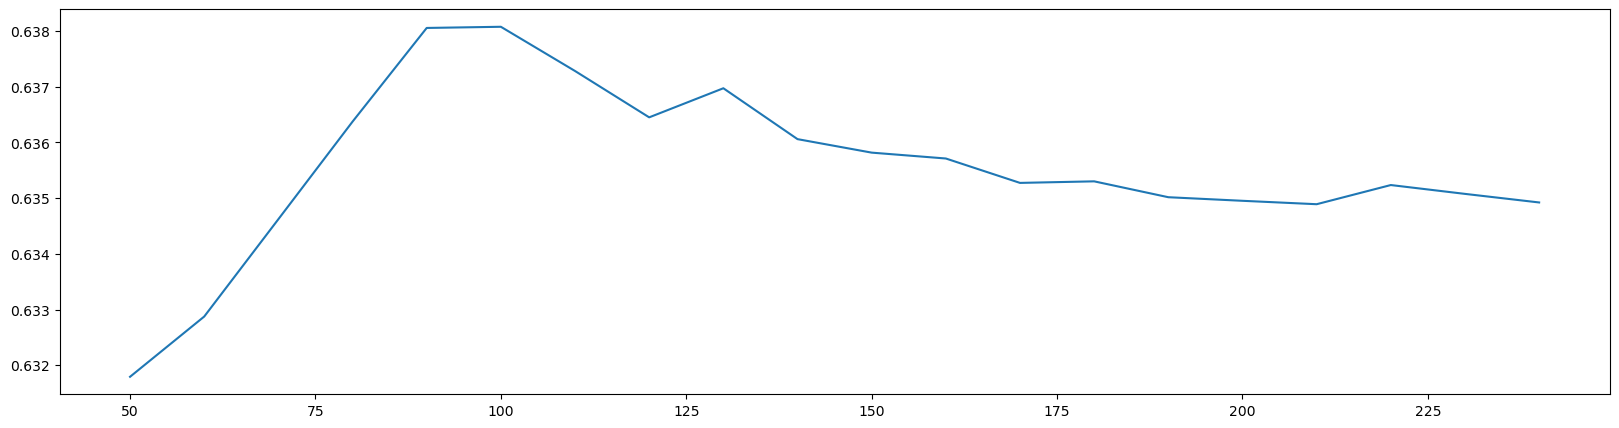

In [35]:
plt.figure(figsize=[20,5])
plt.plot(range(50,250,10),cv_score_list)
plt.show()

In [36]:
cv_score_list=[]
for i in range(91,110):
    rf = RandomForestRegressor(n_estimators=i,
                               n_jobs=-1, random_state=28)
    cv_score = cross_val_score(rf, X_train_8vi, y_train,
                               scoring='r2',
                               cv=3,
                               n_jobs=-1).mean()
    cv_score_list.append(cv_score)
print(max(cv_score_list),([*range(91,110)][cv_score_list.index(max(cv_score_list))]))

0.6380755727957599 100


调节`max_depth`参数

In [37]:
cv_score_list=[]
for i in range(1,11):
    rf = RandomForestRegressor(n_estimators=100,
                               max_depth=i,
                               n_jobs=-1, random_state=28)
    cv_score = cross_val_score(rf, X_train_8vi, y_train,
                               scoring='r2',
                               cv=3,
                               n_jobs=-1).mean()
    cv_score_list.append(cv_score)
print(max(cv_score_list),([*range(1,11)][cv_score_list.index(max(cv_score_list))]))

0.6531335523825014 2


调节`max_features`参数

In [38]:
cv_score_list=[]
for i in range(1,14):
    rf = RandomForestRegressor(n_estimators=100,
                               max_depth=2,
                               max_features=i,
                               n_jobs=-1, random_state=28)
    cv_score = cross_val_score(rf, X_train_8vi, y_train,
                               scoring='r2',
                               cv=3,
                               n_jobs=-1).mean()
    cv_score_list.append(cv_score)
print(max(cv_score_list),([*range(1,14)][cv_score_list.index(max(cv_score_list))]))

0.6601122380263974 10


调节`min_samples_split`参数

In [39]:
cv_score_list=[]
for i in range(2,22):
    rf = RandomForestRegressor(n_estimators=100,
                               max_depth=2,
                               max_features=10,
                               min_samples_split=i,
                               n_jobs=-1, random_state=28)
    cv_score = cross_val_score(rf, X_train_8vi, y_train,
                               scoring='r2',
                               cv=3,
                               n_jobs=-1).mean()
    cv_score_list.append(cv_score)
print(max(cv_score_list),([*range(2,22)][cv_score_list.index(max(cv_score_list))]))

0.6601122380263975 2


调节`min_samples_leaf`参数

In [40]:
cv_score_list=[]
for i in range(1,21):
    rf = RandomForestRegressor(n_estimators=100,
                               max_depth=2,
                               max_features=10,
                               min_samples_split=2,
                               min_samples_leaf=i,
                               n_jobs=-1, random_state=28)
    cv_score = cross_val_score(rf, X_train_8vi, y_train,
                               scoring='r2',
                               cv=3,
                               n_jobs=-1).mean()
    cv_score_list.append(cv_score)
print(max(cv_score_list),([*range(1,21)][cv_score_list.index(max(cv_score_list))]))

0.6601853833469761 12


组合搜索寻求进一步优化

In [41]:
params = {'max_depth':np.arange(1,5),
          'max_features':np.arange(8,13),
          'min_samples_split':np.arange(1,5),
          'min_samples_leaf':np.arange(10,15)}

In [42]:
rf = RandomForestRegressor(n_jobs=-1, random_state=28,
                           n_estimators=100)
rfsearch1 = GridSearchCV(rf, params,
                         scoring='r2',
                         cv=3, n_jobs=-1)
rfsearch1.fit(X_train_8vi, y_train)
print('best_params:',rfsearch1.best_params_)
print('best_score:', rfsearch1.best_score_)

/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
300 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/joblib/parallel.py", line 1098, in __call__
    self.retrieve()
  File "/srv/conda/envs/not

best_params: {'max_depth': 2, 'max_features': 10, 'min_samples_leaf': 12, 'min_samples_split': 3}
best_score: 0.6601853833469761


In [43]:
# random_state
cv_score_list=[]
for i in range(200):
    rf = RandomForestRegressor(n_estimators=100,
                               max_depth=2,
                               max_features=10,
                               min_samples_split=3,
                               min_samples_leaf=12,
                               n_jobs=-1,
                               random_state=i)
    cv_score = cross_val_score(rf, X_train_8vi, y_train,
                               scoring='r2',
                               cv=3,
                               n_jobs=-1).mean()
    cv_score_list.append(cv_score)
print(max(cv_score_list),([*range(200)][cv_score_list.index(max(cv_score_list))]))

0.6630582282969018 93


In [44]:
rf_best = RandomForestRegressor(n_estimators=100,
                                max_depth=2,
                                max_features=10,
                                min_samples_split=3,
                                min_samples_leaf=12,
                                n_jobs=-1,
                                random_state=93)
rf_best.fit(X_train_8vi,y_train)

RandomForestRegressor(max_depth=2, max_features=10, min_samples_leaf=12,
                      min_samples_split=3, n_jobs=-1, random_state=93)

#### 4个VI

In [27]:
cv_score_list = []
for i in range(200,300,10):
    rf = RandomForestRegressor(n_estimators=i,
                               n_jobs=-1, random_state=28)
    cv_score = cross_val_score(rf, X_train_4vi, y_train,
                               scoring='r2',
                               cv=3,
                               n_jobs=-1).mean()
    cv_score_list.append(cv_score)
print(max(cv_score_list),([*range(200,300,10)][cv_score_list.index(max(cv_score_list))]))

0.6338109741890555 270


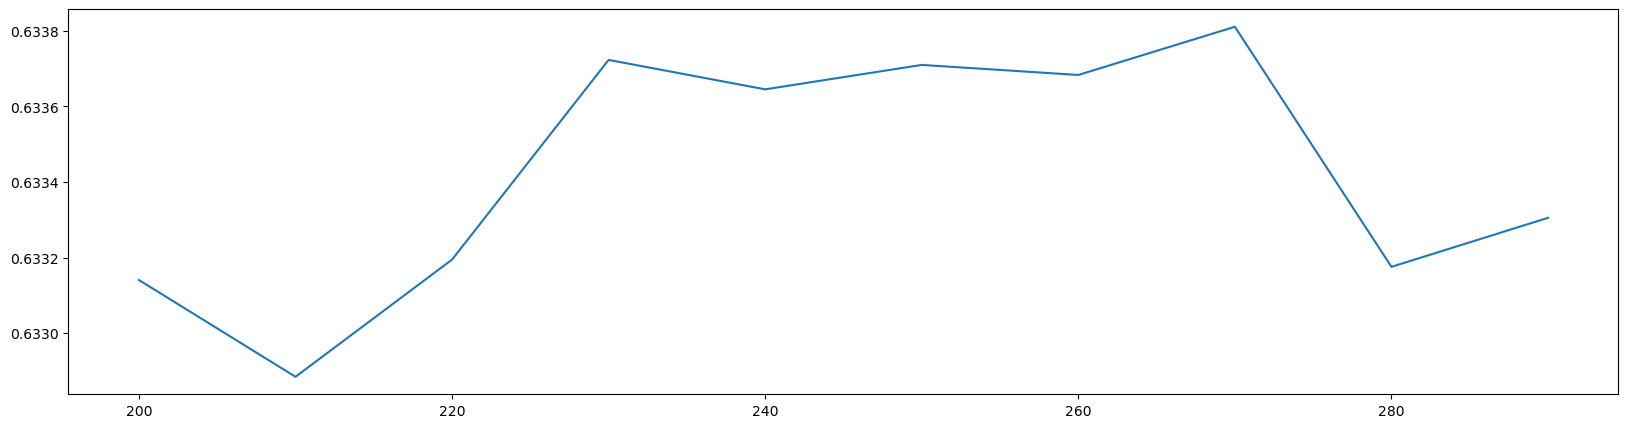

In [28]:
plt.figure(figsize=[20,5])
plt.plot(range(200,300,10),cv_score_list)
plt.show()

In [29]:
cv_score_list=[]
for i in range(261,280):
    rf = RandomForestRegressor(n_estimators=i,
                               n_jobs=-1, random_state=28)
    cv_score = cross_val_score(rf, X_train_4vi, y_train,
                               scoring='r2',
                               cv=3,
                               n_jobs=-1).mean()
    cv_score_list.append(cv_score)
print(max(cv_score_list),([*range(261,280)][cv_score_list.index(max(cv_score_list))]))

0.6338399543734907 262


In [30]:
# max_depth
cv_score_list=[]
for i in range(1,11):
    rf = RandomForestRegressor(n_estimators=262,
                               max_depth=i,
                               n_jobs=-1, random_state=28)
    cv_score = cross_val_score(rf, X_train_4vi, y_train,
                               scoring='r2',
                               cv=3,
                               n_jobs=-1).mean()
    cv_score_list.append(cv_score)
print(max(cv_score_list),([*range(1,11)][cv_score_list.index(max(cv_score_list))]))

0.6523947520992387 1


In [31]:
# max_features
cv_score_list=[]
for i in range(1,14):
    rf = RandomForestRegressor(n_estimators=262,
                               max_depth=1,
                               max_features=i,
                               n_jobs=-1, random_state=28)
    cv_score = cross_val_score(rf, X_train_4vi, y_train,
                               scoring='r2',
                               cv=3,
                               n_jobs=-1).mean()
    cv_score_list.append(cv_score)
print(max(cv_score_list),([*range(1,14)][cv_score_list.index(max(cv_score_list))]))

0.6589391893387483 5


In [32]:
# min_samples_split
cv_score_list=[]
for i in range(2,22):
    rf = RandomForestRegressor(n_estimators=262,
                               max_depth=1,
                               max_features=5,
                               min_samples_split=i,
                               n_jobs=-1, random_state=28)
    cv_score = cross_val_score(rf, X_train_4vi, y_train,
                               scoring='r2',
                               cv=3,
                               n_jobs=-1).mean()
    cv_score_list.append(cv_score)
print(max(cv_score_list),([*range(2,22)][cv_score_list.index(max(cv_score_list))]))

0.6589391893387484 4


In [33]:
# min_samples_leaf
cv_score_list=[]
for i in range(1,21):
    rf = RandomForestRegressor(n_estimators=262,
                               max_depth=1,
                               max_features=5,
                               min_samples_split=4,
                               min_samples_leaf=i,
                               n_jobs=-1, random_state=28)
    cv_score = cross_val_score(rf, X_train_4vi, y_train,
                               scoring='r2',
                               cv=3,
                               n_jobs=-1).mean()
    cv_score_list.append(cv_score)
print(max(cv_score_list),([*range(1,21)][cv_score_list.index(max(cv_score_list))]))

0.6589391893387485 5


### 剔除重要性低的变量

In [30]:
importances = rf_best.feature_importances_
print('重要性：',importances)

重要性： [1.32018811e-04 1.99039493e-02 0.00000000e+00 2.94964288e-02
 3.20256404e-04 8.72602942e-05 1.00888935e-02 0.00000000e+00
 1.10549083e-02 9.62345794e-03 8.71856169e-02 0.00000000e+00
 3.92682038e-02 3.32216097e-04 1.94142427e-02 1.91792704e-02
 2.25246586e-04 1.93243322e-02 4.97577463e-02 4.86708203e-02
 0.00000000e+00 2.41327211e-02 4.68128076e-04 9.75209999e-03
 3.88915379e-02 0.00000000e+00 0.00000000e+00 9.69182001e-03
 2.92598679e-02 0.00000000e+00 3.92259627e-02 0.00000000e+00
 1.80706195e-04 4.04588065e-04 0.00000000e+00 1.93835536e-04
 2.90671562e-02 2.91991914e-02 9.10705373e-05 2.01935955e-02
 2.25300622e-04 0.00000000e+00 9.77733619e-03 0.00000000e+00
 4.85190840e-02 2.94480935e-02 2.92681096e-02 2.92556385e-02
 0.00000000e+00 1.94444671e-02 5.35411436e-03 0.00000000e+00
 1.07143672e-04 0.00000000e+00 2.95127408e-02 1.98106893e-02
 1.95130184e-02 0.00000000e+00 1.95350916e-02 0.00000000e+00
 1.02188803e-04 8.92963136e-05 0.00000000e+00 1.08125904e-02
 5.39438457e-04 1.9

In [31]:
indices = sum(np.argwhere(importances==0).tolist(),[])  ##将重要性为0的特征索引转化为列表
len(indices)

44

In [32]:
X_filtered = np.delete(X_train,indices,axis=1)
X_filtered.shape

(557, 102)

In [33]:
y_filtered = y_train
y_filtered.shape

(557,)

In [34]:
cv_score = cross_val_score(rf_best, X_filtered, y_filtered,
                           scoring='r2',
                           cv=3,
                           n_jobs=-1).mean()
cv_score

0.6600280543944407

## 输出预测

In [45]:
sub_weather = np.load('submission_weather_data.npz')
sub_vi = np.load('submission_data.npz')
sub_freq = np.load('submission_data_freq.npz')

In [46]:
sub_weather_data = sub_weather['arr_0']
sub_vi_data = sub_vi['arr_0']
sub_freq = sub_freq['arr_0']

In [47]:
sub_weather_data_2D = np.reshape(sub_weather_data,(100,sub_weather_data.shape[1]*sub_weather_data.shape[2]))
sub_weather_data_2D.shape

(100, 72)

In [48]:
sub_vi_data_3D = np.mean(np.mean(sub_vi_data,axis=4),axis=3)
sub_vi_data_2D = np.reshape(sub_vi_data_3D,(100,sub_vi_data_3D.shape[1]*sub_vi_data_3D.shape[2]),order='F')
sub_vi_data_2D.shape

(100, 64)

In [50]:
sub_yield_data = pd.read_csv('Challenge_2_submission_template.csv')
sub_yield_data

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha)
0,1,Chau_Phu,10.542192,105.187920,WS,T,10-04-2022,1.40,NaN
1,2,Chau_Thanh,10.400189,105.331053,SA,T,15-07-2022,1.32,NaN
2,3,Chau_Phu,10.505489,105.203926,SA,D,14-07-2022,1.40,NaN
3,4,Chau_Phu,10.523520,105.138274,WS,D,10-04-2022,1.80,NaN
4,5,Thoai_Son,10.294660,105.248528,SA,T,20-07-2022,2.20,NaN
...,...,...,...,...,...,...,...,...,...
95,96,Chau_Thanh,10.435839,105.132981,SA,D,26-07-2022,1.21,NaN
96,97,Chau_Phu,10.529357,105.147388,WS,T,10-04-2022,2.00,NaN
97,98,Chau_Thanh,10.452537,105.205118,SA,T,20-07-2022,5.50,NaN
98,99,Chau_Thanh,10.394341,105.126836,SA,T,14-07-2022,4.40,NaN


In [51]:
sub_cycle_number = pd.get_dummies(sub_yield_data['Rice Crop Intensity(D=Double, T=Triple)'])  #生成D、T两列
sub_cycle_number = np.reshape(np.array(sub_cycle_number['D']),(-1,1))   #以D=1，T=1，(-1,1)指转化为一列
sub_field_size = np.reshape(np.array(sub_yield_data['Field size (ha)']),(-1,1))

In [52]:
X_test = np.concatenate((sub_weather_data_2D,sub_vi_data_2D,sub_freq,sub_cycle_number,sub_field_size),axis=1)
X_test.shape

(100, 146)

In [53]:
y_pred = rf_best.predict(X_test)

In [55]:
df1 = sub_yield_data.drop(columns=['Predicted Rice Yield (kg/ha)'])
df2 = pd.DataFrame(y_pred)
df2.columns=['Predicted Rice Yield (kg/ha)']
submission = pd.concat([df1,df2],axis=1)

In [56]:
submission

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha)
0,1,Chau_Phu,10.542192,105.187920,WS,T,10-04-2022,1.40,7234.462586
1,2,Chau_Thanh,10.400189,105.331053,SA,T,15-07-2022,1.32,5930.640399
2,3,Chau_Phu,10.505489,105.203926,SA,D,14-07-2022,1.40,5911.705326
3,4,Chau_Phu,10.523520,105.138274,WS,D,10-04-2022,1.80,7265.888885
4,5,Thoai_Son,10.294660,105.248528,SA,T,20-07-2022,2.20,5923.471851
...,...,...,...,...,...,...,...,...,...
95,96,Chau_Thanh,10.435839,105.132981,SA,D,26-07-2022,1.21,5941.060070
96,97,Chau_Phu,10.529357,105.147388,WS,T,10-04-2022,2.00,7259.581705
97,98,Chau_Thanh,10.452537,105.205118,SA,T,20-07-2022,5.50,5939.623409
98,99,Chau_Thanh,10.394341,105.126836,SA,T,14-07-2022,4.40,5916.137482


In [57]:
submission.to_csv('submission_rf4.csv')